# Imports

In [1]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats
import graphviz
import astropy.units as u

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_33866/1667230561.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [3]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data

## Tess

In [4]:
#sectors times, 15-22-23-48-50
from astropy.time import Time
sectors = ['2019-08-15T20:45:00','2019-09-10T22:00:00','2020-02-19T19:20:00','2020-03-18T00:00:00',
'2020-03-19T14:30:00','2020-04-15T09:10:00','2022-01-28T10:25:00','2022-02-25T11:50:00','2022-03-26T18:30:00','2022-04-22T00:25:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([1711.36458333, 1737.41666667, 1899.30555556, 1926.5       ,
       1928.10416667, 1954.88194444, 2607.93402778, 2635.99305556,
       2665.27083333, 2691.51736111])

In [5]:
lk.search_lightcurve('TIC 445859771')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
2,TESS Sector 15,2019,QLP,1800,445859771,0.0
3,TESS Sector 15,2019,TASOC,120,445859771,0.0
4,TESS Sector 15,2019,TASOC,1800,445859771,0.0
5,TESS Sector 15,2019,TASOC,1800,445859771,0.0
6,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 16,2019,QLP,1800,445859771,0.0
8,TESS Sector 22,2020,SPOC,120,445859771,0.0


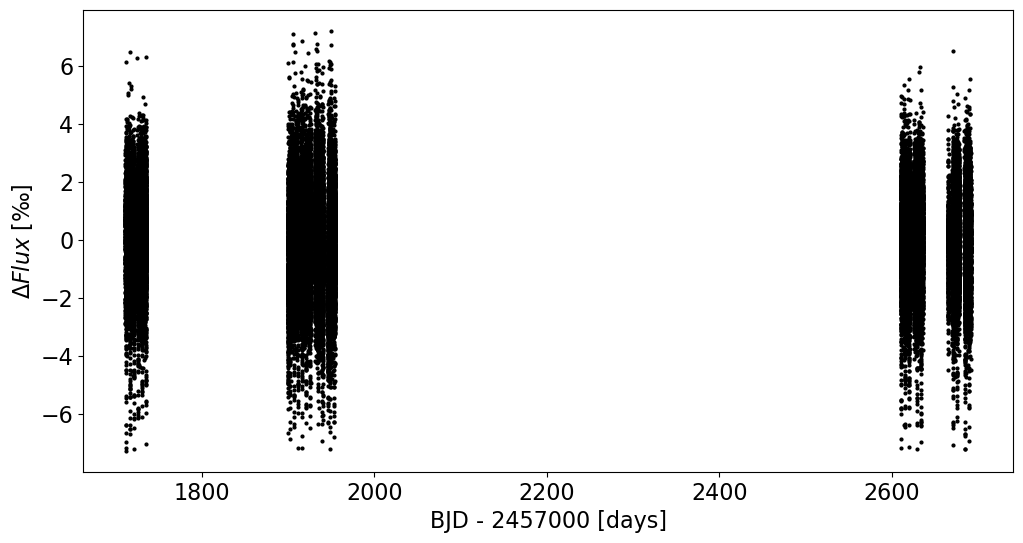

In [6]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='black',markersize=2)
#plt.errorbar(time, (flux-1.0)*1e3, yerr=lc.flux_err*1e3, color='k', fmt='o', ms=2)
plt.xlabel("BJD - 2457000 [days]")
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.show()
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

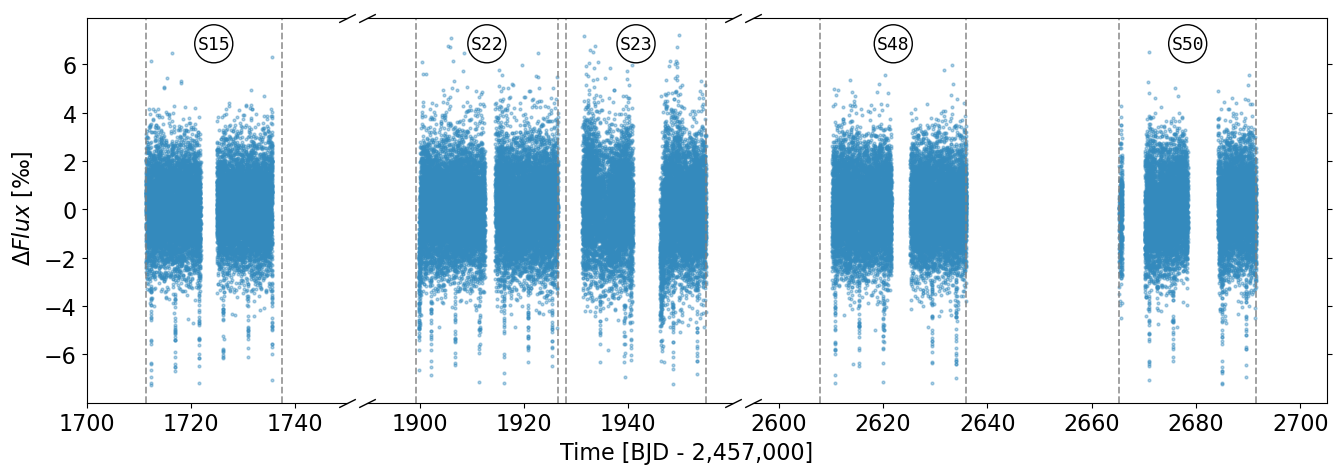

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1.4, 2.2]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax3.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
off=15
ax1.set_xlim(1700, 1750)  
ax2.set_xlim(1890, 1960)  
ax3.set_xlim(2595, 2705)  
ax2.set_xticks([1900, 1920, 1940])
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax3.spines.left.set_visible(False)
ax1.yaxis.tick_left()
#ax2.set_yticks([])
ax2.yaxis.tick_right()
ax3.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelright=False)
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:6]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[6:]:
    ax3.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 6.85, 
    "S15", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 6.85, 
    "S22", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[4]+(sectors_times_btjd[5]-sectors_times_btjd[4])/2, 6.85, 
    "S23", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[6]+(sectors_times_btjd[7]-sectors_times_btjd[6])/2, 6.85, 
    "S48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[8]+(sectors_times_btjd[9]-sectors_times_btjd[8])/2, 6.85, 
    "S50", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))

fig.text(0.5, 0.01, "Time [BJD - 2,457,000]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
#plt.savefig('tessdata_1273.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

BLS

In [8]:
period_grid = np.exp(np.linspace(np.log(2), np.log(8), 30000)) #2 y 8 ---- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100)) #0.01 y 0.2 

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 4.631374375019575
bls t0: -489.0987763358155
bls depth: 3.6049340566184895
ref_time: 2201.436872421974
epoch: 1712.3380960861584
bls duration: 0.05266666666666668


In [9]:
# 1 y 30 grid
# bls period: 4.631191916352005
# bls t0: -489.0772763358155
# bls depth: 3.6220594837807694
# ref_time: 2201.436872421974
# epoch: 1712.3595960861585
# bls duration: 0.04833333333333336

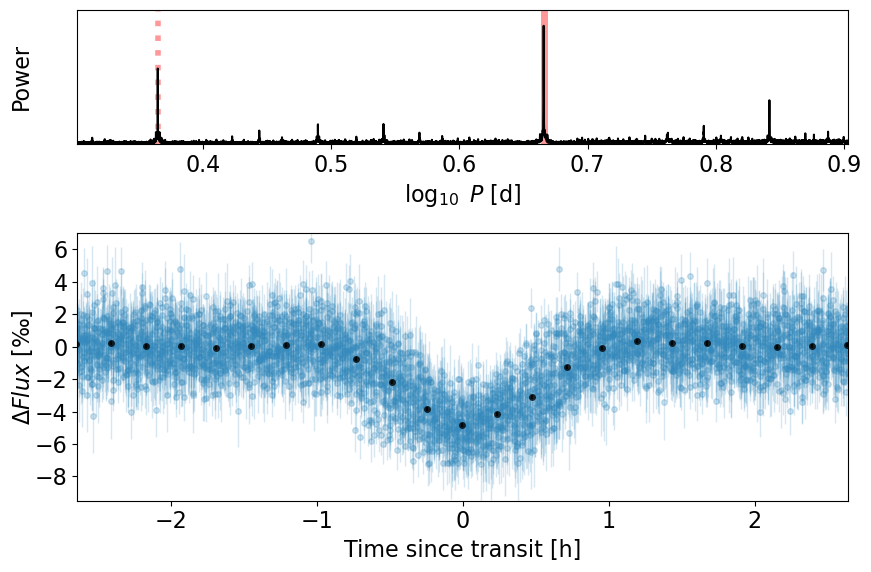

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color='red', lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, color="k")
ax1.set_ylim(0,3000)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.25, ms=8, color='#348ABD')
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, color='#348ABD', fmt="none", capsize=0, elinewidth=1, zorder=-1000, alpha=0.2)

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold_, flux=y_, flux_err=yerr_)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylim(-9.5, 7)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")
plt.tight_layout()

#plt.savefig('bls_paper_1273.png',dpi=300,bbox_inches='tight', facecolor='white')

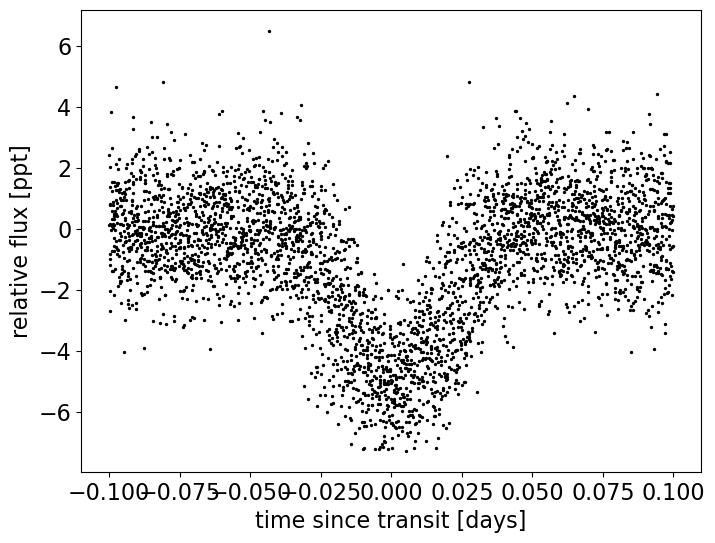

In [11]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
#plt.xlim(-0.12,0.12)

## SOPHIE RVs

60


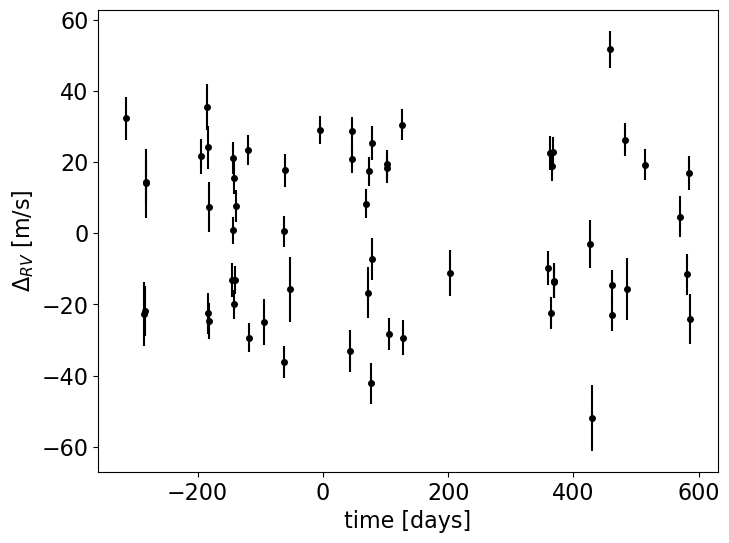

In [12]:
data = pd.read_table('./data/rvs/1273_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [13]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

K= [26.47708999] m/s
minimum mass= [68.09246812] earthMass


Periodograms

In [14]:
from astropy.timeseries import LombScargle

In [15]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)

frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)

In [ ]:
# compute model

In [39]:
# aliases computed in DACE
aliases = [1.275, 1.271, 0.822, 0.821]

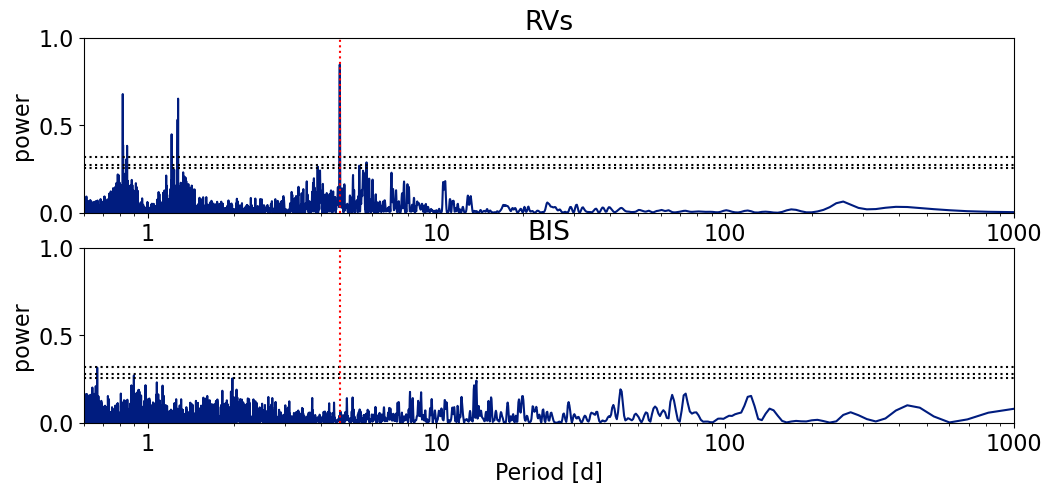

In [38]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 5))
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 

axes[0].set_xlabel('')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('Period [d]')
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[0].title.set_text('RVs')
axes[1].title.set_text('BIS')

# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)

plt.show()

BIS vs rvs

Text(0, 0.5, '$\\Delta$BIS [m/s]')

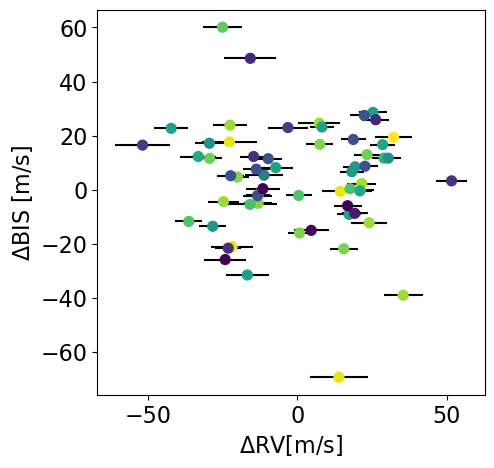

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(y_rv, data.bis*1e3, c=data.bjd, cmap='viridis_r', s=50, zorder=10)
# add errorbars on data.rv
ax.errorbar(y_rv, data.bis*1e3, xerr=yerr_rv, fmt='none', ecolor='k', markersize=8, zorder=-10)

ax.set_xlabel("$\Delta$RV[m/s]")
ax.set_ylabel("$\Delta$BIS [m/s]")
plt.show()

## Ground LCs

### Keplercam

In [18]:
# all have the same columns
data1 = pd.read_table('./data/photom/TOI1273/TIC445859771.01_UT2020.0213_KeplerCam_B.txt', sep='\s+')

In [19]:
#puntos?
print('puntos:', len(data1))
# texp?
texp_keplercam = None

puntos: 135


In [20]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data1['time'] = data1['BJD_TDB']-2457000-ref_time
data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3

Text(0.5, 1.0, 'TOI1273')

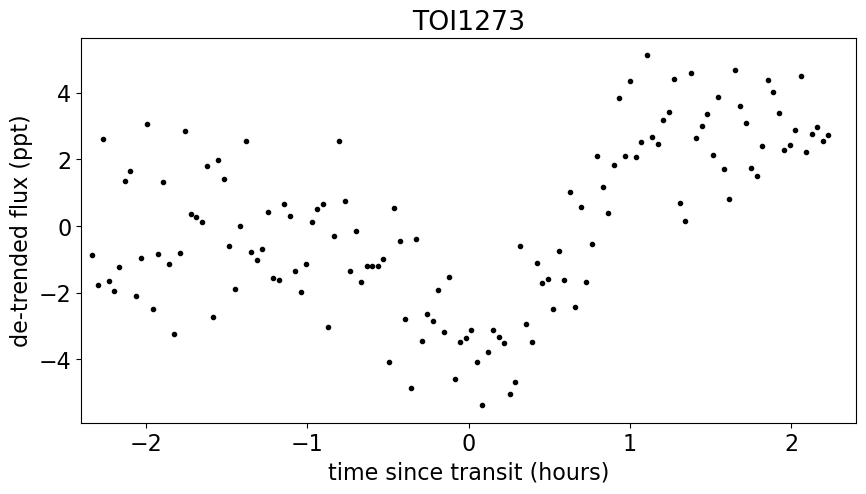

In [21]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux']-1e3, ".k", label="data1", zorder=-1000)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")

In [22]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], bls_period, bls_duration, bls_t0)
x_oot_B = (data1_fold*24)[~oot_mask1]
y_oot_B = data1['flux'][~oot_mask1]
z_B = np.polyfit(x_oot_B, y_oot_B, 2)
def pol_B(x):
    return np.asarray(z_B[0]*x**2 + z_B[1]*x + z_B[2])

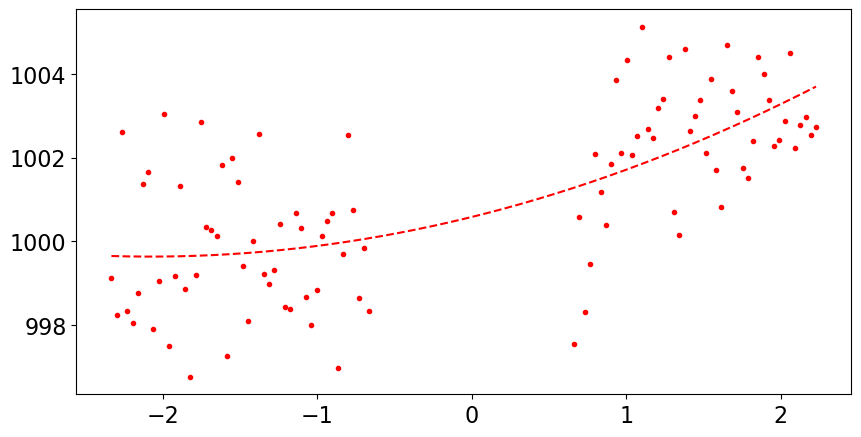

In [23]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".r", label="data1", zorder=-1000)
x_plot_B = np.linspace(np.min(x_oot_B), np.max(x_oot_B), 1000)
plt.plot(x_plot_B, pol_B(x_plot_B), color="r", linestyle="--")


In [24]:
x_conc_B = data1_fold*24
y_conc_B = (data1['flux']/pol_B(data1_fold*24)-1)*1e3
yerr_conc_B = data1['flux_err']

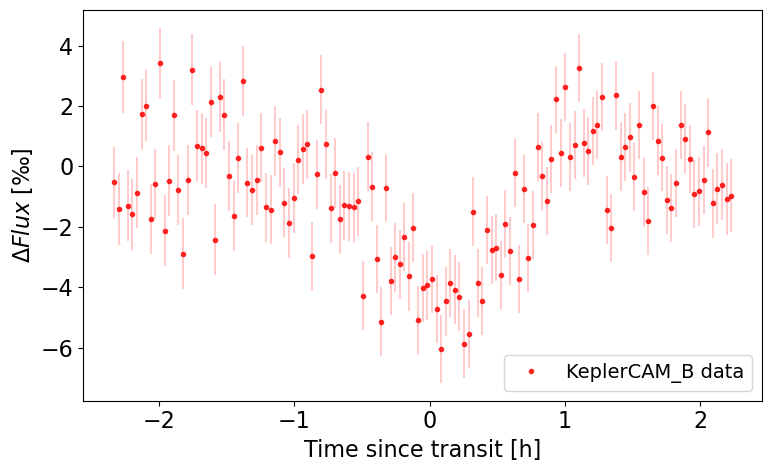

In [25]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', 
         label='KeplerCAM_B data', zorder=1000, alpha=0.8)
plt.errorbar(x_conc_B, y_conc_B, yerr=yerr_conc_B, 
             fmt="none", color='r', capsize=0, zorder=-1000, alpha=0.2)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [57]:
# datos de keplercam finales
x_keplercam_B = np.ascontiguousarray(data1['time'], dtype=np.float64)
y_keplercam_B = np.ascontiguousarray(y_conc_B, dtype=np.float64)
yerr_keplercam_B = np.ascontiguousarray(yerr_conc_B, dtype=np.float64)

### Muscat

In [58]:
data2 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_zs_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data3 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_g_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data4 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_i_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data5 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_r_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
# Convert time to the same reference time as tess and flux to ppt
data2['bjd'] = data2['BJD_TDB']-2457000-ref_time
data3['bjd'] = data3['BJD_TDB']-2457000-ref_time
data4['bjd'] = data4['BJD_TDB']-2457000-ref_time
data5['bjd'] = data5['BJD_TDB']-2457000-ref_time

data2['flux'] = np.ascontiguousarray(1e3 * (data2['flux'] - 1.0), dtype=np.float64) 
data3['flux'] = np.ascontiguousarray(1e3 * (data3['flux'] - 1.0), dtype=np.float64) 
data4['flux'] = np.ascontiguousarray(1e3 * (data4['flux'] - 1.0), dtype=np.float64) 
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 

data2['flux_err'] = np.ascontiguousarray(1e3 * (data2['flux_err']), dtype=np.float64) 
data3['flux_err'] = np.ascontiguousarray(1e3 * (data3['flux_err']), dtype=np.float64) 
data4['flux_err'] = np.ascontiguousarray(1e3 * (data4['flux_err']), dtype=np.float64) 
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 

In [59]:
print(len(data2), len(data3), len(data4), len(data5))

1772 1771 1772 1770


In [60]:
# Texp?
print(np.median(np.diff(data2['bjd']))*24*60*60)
texp_muscat = None

9.049759805202484


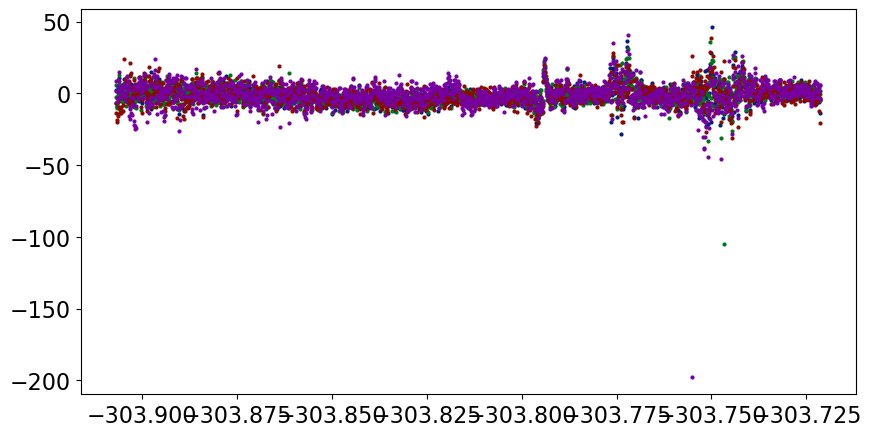

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='z', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='z', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='z', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.show()

In [62]:
# remove outliers 
data2 = data2[np.abs(data2.flux - np.median(data2.flux)) < 3 * np.std(data2.flux)]
data3 = data3[np.abs(data3.flux - np.median(data3.flux)) < 3 * np.std(data3.flux)]
data4 = data4[np.abs(data4.flux - np.median(data4.flux)) < 3 * np.std(data4.flux)]
data5 = data5[np.abs(data5.flux - np.median(data5.flux)) < 3 * np.std(data5.flux)]

In [63]:
print(len(data2), len(data3), len(data4), len(data5))

1746 1748 1747 1756


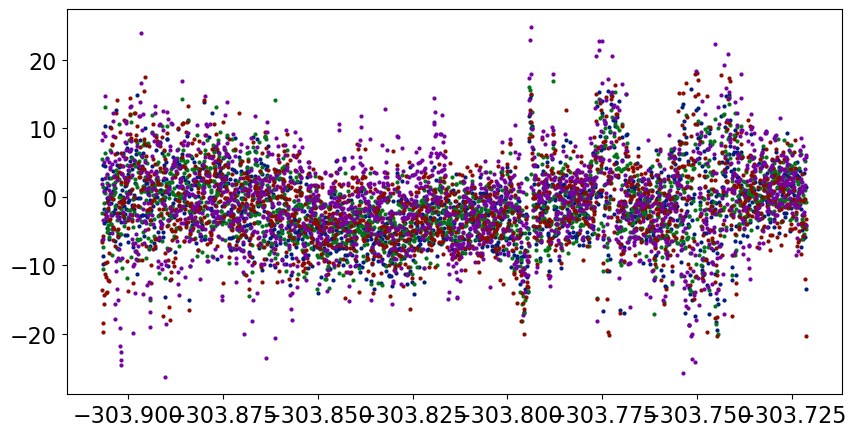

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='zs', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='g', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='i', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='r', ms=2)
plt.show()

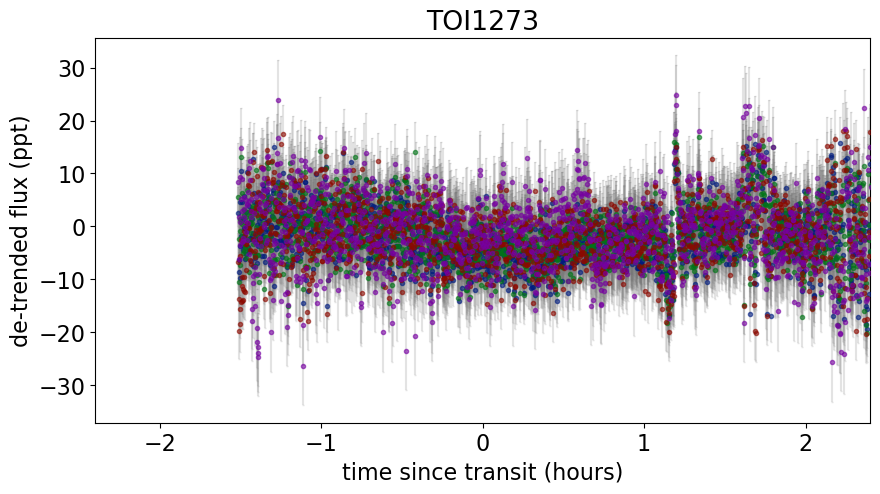

In [65]:
# Plot the folded data, con los parametros del BLS
data2_fold = (data2['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data2_fold, data3_fold, data4_fold, data5_fold], ignore_index=True)
# datos finales muscat
x_muscat_zs_ = np.ascontiguousarray(data2['bjd'], dtype=np.float64)
x_muscat_g_ = np.ascontiguousarray(data3['bjd'], dtype=np.float64)
x_muscat_i_ = np.ascontiguousarray(data4['bjd'], dtype=np.float64)
x_muscat_r_ = np.ascontiguousarray(data5['bjd'], dtype=np.float64)
y_muscat_zs_ = np.ascontiguousarray(data2['flux'], dtype=np.float64)
y_muscat_g_ = np.ascontiguousarray(data3['flux'], dtype=np.float64)
y_muscat_i_ = np.ascontiguousarray(data4['flux'], dtype=np.float64)
y_muscat_r_ = np.ascontiguousarray(data5['flux'], dtype=np.float64)
yerr_muscat_zs_ = np.ascontiguousarray(data2['flux_err'], dtype=np.float64)
yerr_muscat_g_ = np.ascontiguousarray(data3['flux_err'], dtype=np.float64)
yerr_muscat_i_ = np.ascontiguousarray(data4['flux_err'], dtype=np.float64)
yerr_muscat_r_ = np.ascontiguousarray(data5['flux_err'], dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(data2_fold*24, y_muscat_zs_, '.', label='Muscat2_zs', alpha=0.6, zorder=100)
plt.errorbar(data2_fold*24, y_muscat_zs_, yerr=yerr_muscat_zs_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data3_fold*24, y_muscat_g_, '.', label='Muscat2_g', alpha=0.6, zorder=100)
plt.errorbar(data3_fold*24, y_muscat_g_, yerr=yerr_muscat_g_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data4_fold*24, y_muscat_i_, '.', label='Muscat2_i', alpha=0.6, zorder=100)
plt.errorbar(data4_fold*24, y_muscat_i_, yerr=yerr_muscat_i_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data5_fold*24, y_muscat_r_, '.', label='Muscat2_r', alpha=0.6, zorder=100)
plt.errorbar(data5_fold*24, y_muscat_r_, yerr=yerr_muscat_r_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [66]:
# mask the second half of the transit?
x_muscat_zs = x_muscat_zs_[data2_fold*24<0.5]
x_muscat_g = x_muscat_g_[data3_fold*24<0.5]
x_muscat_i = x_muscat_i_[data4_fold*24<0.5]
x_muscat_r = x_muscat_r_[data5_fold*24<0.5]
y_muscat_zs = y_muscat_zs_[data2_fold*24<0.5]
y_muscat_g = y_muscat_g_[data3_fold*24<0.5]
y_muscat_i = y_muscat_i_[data4_fold*24<0.5]
y_muscat_r = y_muscat_r_[data5_fold*24<0.5]
yerr_muscat_zs = yerr_muscat_zs_[data2_fold*24<0.5]
yerr_muscat_g = yerr_muscat_g_[data3_fold*24<0.5]
yerr_muscat_i = yerr_muscat_i_[data4_fold*24<0.5]
yerr_muscat_r = yerr_muscat_r_[data5_fold*24<0.5]

print(len(x_muscat_zs), len(y_muscat_zs), len(yerr_muscat_zs))
print(len(x_muscat_g), len(y_muscat_g), len(yerr_muscat_g))
print(len(x_muscat_i), len(y_muscat_i), len(yerr_muscat_i))
print(len(x_muscat_r), len(y_muscat_r), len(yerr_muscat_r))

801 801 801
801 801 801
798 798 798
801 801 801


# LC dataset

In [67]:
from collections import OrderedDict

datasets = OrderedDict(
    [
        ("tess", [x, y, yerr, texp]),
        ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
        ('muscat_zs', [x_muscat_zs, y_muscat_zs, yerr_muscat_zs, texp_muscat]),
        ('muscat_g', [x_muscat_g, y_muscat_g, yerr_muscat_g, texp_muscat]),
        ('muscat_i', [x_muscat_i, y_muscat_i, yerr_muscat_i, texp_muscat]),
        ('muscat_r', [x_muscat_r, y_muscat_r, yerr_muscat_r, texp_muscat])
    ]
)

In [68]:
# print type of all arrays in datasets
for key in datasets:
    print(key, type(datasets[key][0]), type(datasets[key][1]), type(datasets[key][2]), type(datasets[key][3]))
    

tess <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'float'>
keplercam_B <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_zs <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_g <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_i <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_r <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>


# Joint model

In [69]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 500)

for i in range(10):
    with pm.Model() as model:
        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # b = pmx.UnitUniform("b")
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1)
        #log_ror = pm.Normal("log_ror", mu=-2.90, sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        b = xo.ImpactParameter('b', ror)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        transit_obs = dict()
        lc_pred = dict()

        for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sd=5.0)
                # The limb darkening
                u_star = xo.QuadLimbDark("u_star")
                star = xo.LimbDarkLightCurve(u_star)

                # Transit jitter
                logs = pm.Normal("logs", mu=np.log(np.median(yerr_)), sd=1)
                
                # Keep track of the parameters for optimization
                parameters[name] = [mean, u_star, logs]

            # The light curve model
            def lc_model(mean, star, r_pl, texp, t):
                return tt.sum((star.get_light_curve(orbit=orbit, r=r_pl, 
                                                        t=t, texp=texp)* 1e3), axis=-1) + mean

            #lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model(mean, star, r_pl, texp_, x_)

            # The likelihood for the light curve
            err_lc = tt.sqrt(yerr_**2 + tt.exp(2*logs)) 
            transit_obs = pm.Normal(f"{name}_obs", mu=lc_models[name], sd=err_lc, observed=y_) 

            # # Compute and save the phased light curve models
            pm.Deterministic(f"{name}_lc_pred", 1e3 * star.get_light_curve(orbit=orbit, 
                                                                    r=r_pl, t=t0 + phase_lc, 
                                                                    texp=texp_)[..., 0],)

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name] + [ecs, b, log_period])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_sigma_rv, trend, log_sigma_rv])
        map_soln = pmx.optimize(map_soln)

        extras = dict()
        for name in datasets:
            extras[name] = pmx.eval_in_model(lc_models[name], map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(lc_models[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

message: Optimization terminated successfully.
logp: -20438.028655764694 -> -19181.95680291641


message: Optimization terminated successfully.
logp: -19181.95680291641 -> -19072.636014301323


message: Optimization terminated successfully.
logp: -19072.636014301323 -> -18943.058129563546


message: Optimization terminated successfully.
logp: -18943.058129563546 -> -18778.886541870994


message: Optimization terminated successfully.
logp: -18778.886541870994 -> -18683.49869352922


message: Optimization terminated successfully.
logp: -18683.49869352922 -> -18540.08782991189


message: Desired error not necessarily achieved due to precision loss.
logp: -18540.08782991189 -> -17437.958112451422


message: Desired error not necessarily achieved due to precision loss.
logp: -17437.958112451426 -> -17407.71249487701


message: Desired error not necessarily achieved due to precision loss.
logp: -17407.71249487701 -> -17321.6048630573


message: Desired error not necessarily achieved due to precision loss.
logp: -17321.6048630573 -> -17300.56391820254


message: Desired error not necessarily achieved due to precision loss.
logp: -17300.56391820254 -> -17235.41916026338


message: Desired error not necessarily achieved due to precision loss.
logp: -17235.419160263376 -> -17235.216345449986


message: Desired error not necessarily achieved due to precision loss.
logp: -17235.216345449993 -> -17192.284039890896


message: Optimization terminated successfully.
logp: -17192.284039890896 -> -17192.27600403348


message: Desired error not necessarily achieved due to precision loss.
logp: -17192.27600403348 -> -17163.09770601768


message: Optimization terminated successfully.
logp: -17163.09770601768 -> -17163.09350505321


message: Desired error not necessarily achieved due to precision loss.
logp: -17163.09350505321 -> -17150.130217564372


message: Optimization terminated successfully.
logp: -17150.130217564376 -> -17150.129753666337


message: Desired error not necessarily achieved due to precision loss.
logp: -17150.129753666333 -> -16601.278313287417


Sigma clipped 0 tess light curve points
Sigma clipped 0 keplercam_B light curve points
Sigma clipped 0 muscat_zs light curve points
Sigma clipped 0 muscat_g light curve points
Sigma clipped 0 muscat_i light curve points
Sigma clipped 0 muscat_r light curve points


MAP rv model

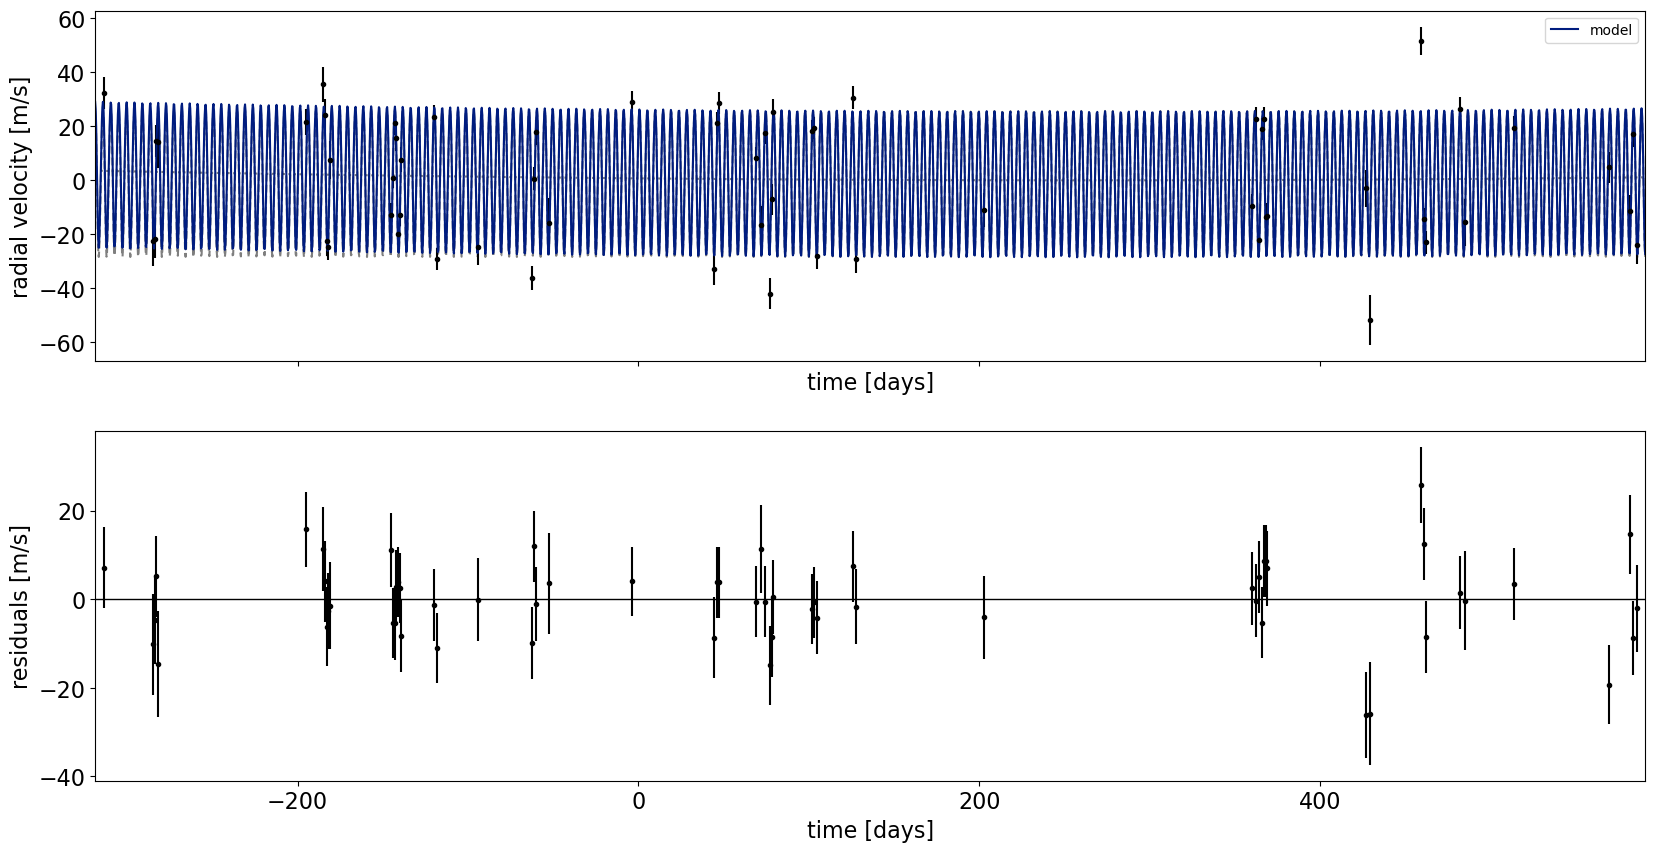

In [70]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln)

MAP LCs models

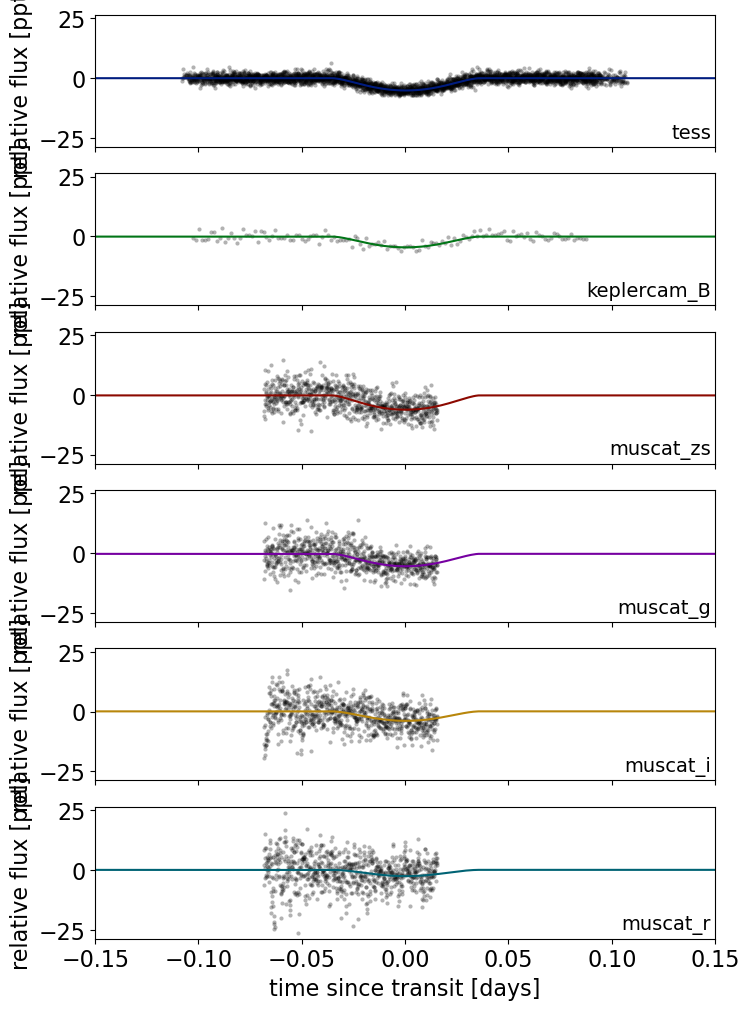

In [72]:
fig, axes = plt.subplots(6, sharex=True, sharey=True, figsize=(8, 12))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y  - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        phase_lc, map_soln[name+'_lc_pred'] - map_soln[f"{name}_mean"], f"C{n}", label=name
    )
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

In [73]:
# pm.model_to_graphviz(model)

# Sampling

In [74]:
import multiprocessing

with model:
    trace_ = pmx.sample(
        tune=1500, #2500,
        draws=1500, #2000,
        start=map_soln,
        cores=2, #4
        chains=2, #4
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_logs, tess_u_star, tess_mean, trend, log_sigma_rv, ecs, b, log_ror, log_period, log_m_pl, t0, r_star, m_star]
NUTS: [muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_logs, tess_u_star, tess_mean, trend, log_sigma_rv, ecs, b, log_ror, log_period, log_m_pl, t0, r_star, m_star]


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 1808 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9004095825191389, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [75]:
import arviz as az
# version con e libre
# az.to_netcdf(trace, 'trace.toi1273.save')
##trace = az.from_netcdf('trace.toi1273.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1273_noecc.save')
# trace = az.from_netcdf('trace.toi1273_noecc.save')

In [77]:
#trace.posterior.data_vars
# print only the names
trace=trace_
for n, var in enumerate(trace.posterior.data_vars):
    if n<=15:
        print(n, var)

0 t0
1 log_m_pl
2 log_period
3 log_ror
4 log_sigma_rv
5 trend
6 tess_mean
7 tess_logs
8 keplercam_B_mean
9 keplercam_B_logs
10 muscat_zs_mean
11 muscat_zs_logs
12 muscat_g_mean
13 muscat_g_logs
14 muscat_i_mean
15 muscat_i_logs


Summary stats

In [78]:
az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
           var_names=[
               't0',
               'log_m_pl',
               'log_period',
               'log_ror',
               'log_sigma_rv',
               'trend',
               'tess_mean',
               'tess_logs',
               'keplercam_B_mean',
               'keplercam_B_logs',
               'muscat_zs_mean',
               'muscat_zs_logs',
               'muscat_g_mean',
               'muscat_g_logs',
               'muscat_i_mean',
               'muscat_i_logs',
               'muscat_r_mean',
               'muscat_r_logs',
               'm_star',
               'r_star',
               'ror',
               'r_pl',
               'b',
               'm_pl',
               'period',
               'ecs',
               'ecc',
               'omega',
               'tess_u_star',
               'keplercam_B_u_star',
               'muscat_zs_u_star',
               'muscat_g_u_star',
               'muscat_i_u_star',
               'muscat_r_u_star',
           ])

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,-489.090381,0.000518,-489.090861,-489.089899,0.000019,0.000014,1065.403925,405.476588,1.003057,-489.090362,0.000518
log_m_pl,4.229327,0.060770,4.175623,4.291883,0.001039,0.000735,3443.094388,2157.654244,1.001082,4.231826,0.060760
log_period,1.532837,0.000001,1.532836,1.532838,0.000000,0.000000,3416.661353,1683.741649,1.000475,1.532837,0.000001
log_ror,-2.168770,0.467077,-2.447920,-2.158852,0.066599,0.047374,215.925977,38.752853,1.006043,-2.297742,0.466999
log_sigma_rv,2.000609,0.154241,1.872949,2.184110,0.003361,0.002377,2199.764998,1863.901539,1.000247,2.002596,0.154215
trend[0],0.000010,0.000015,-0.000005,0.000025,0.000000,0.000000,3779.964449,2033.579054,1.003010,0.000010,0.000015
trend[1],-0.002785,0.004627,-0.007239,0.001814,0.000078,0.000077,3565.182299,2133.723081,1.000292,-0.002786,0.004626
trend[2],0.057754,0.896610,-0.735375,1.039393,0.013461,0.017869,4432.765993,2053.383947,1.003489,0.055222,0.896460
tess_mean,0.096418,0.031425,0.066136,0.126360,0.000483,0.000361,4282.346216,2128.727394,1.000783,0.096229,0.031420
tess_logs,-2.242424,0.429139,-2.538783,-1.722590,0.008118,0.006176,3257.725893,1709.351153,1.000596,-2.196593,0.429067


array([[<Axes: title={'center': 'keplercam_B_u_star\n0'}>,
        <Axes: title={'center': 'keplercam_B_u_star\n1'}>,
        <Axes: title={'center': 'muscat_zs_u_star\n0'}>],
       [<Axes: title={'center': 'muscat_zs_u_star\n1'}>,
        <Axes: title={'center': 'muscat_g_u_star\n0'}>,
        <Axes: title={'center': 'muscat_g_u_star\n1'}>]], dtype=object)

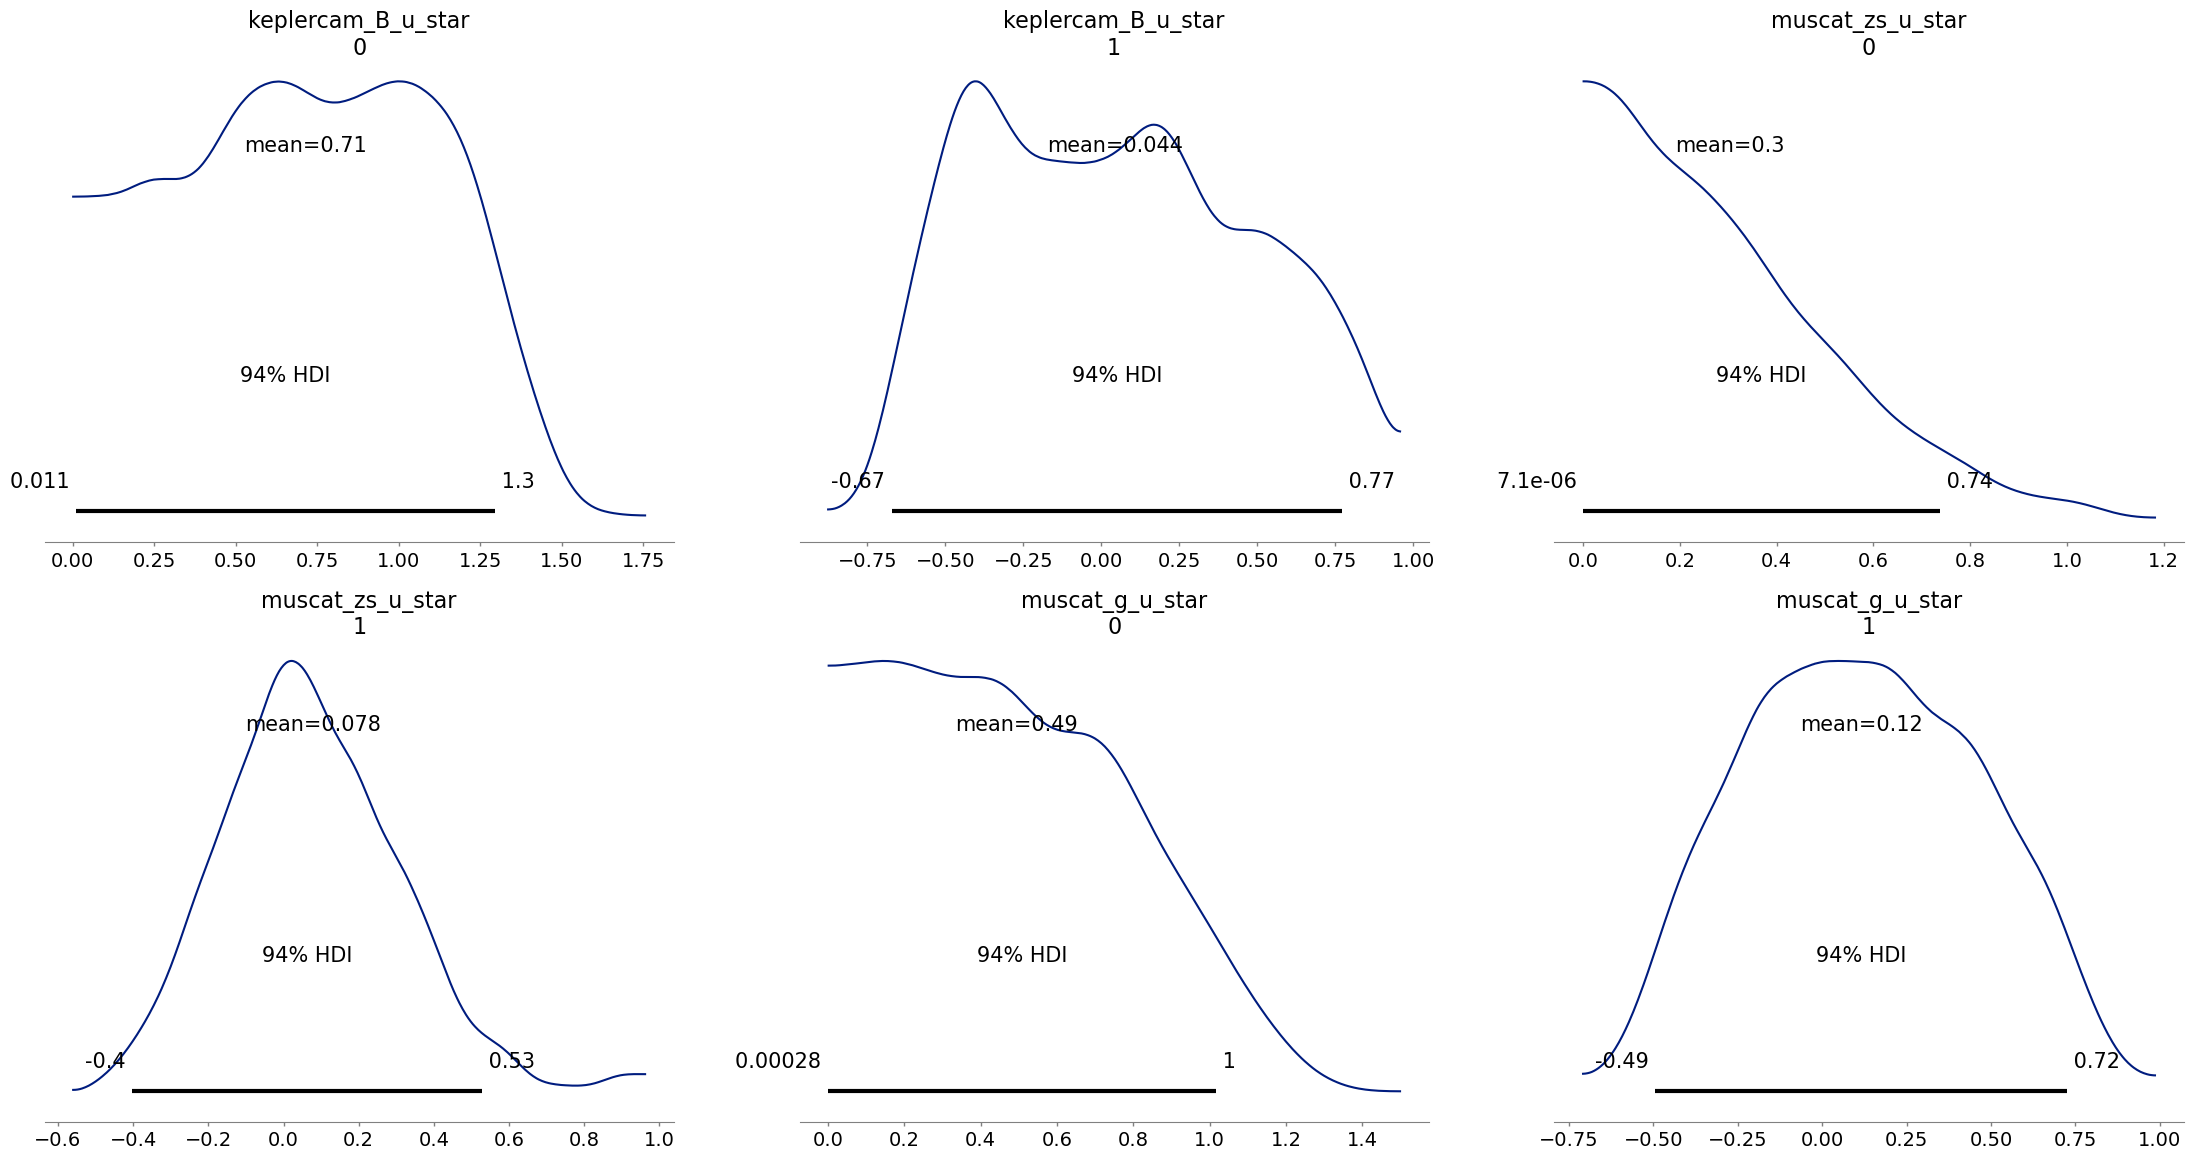

In [79]:
az.plot_posterior(trace, var_names=['keplercam_B_u_star', 'muscat_zs_u_star', 'muscat_g_u_star'])
#plt.savefig('ustar_posteriors.png', dpi=200, bbox_inches='tight')

In [80]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
tess_jitter_median = trace.posterior['tess_logs'].median().item()
tess_jitter = ufloat(tess_jitter_median, trace.posterior['tess_logs'].std().item())
tess_jitter_val = np.e**tess_jitter
keplercam_B_jitter_median = trace.posterior['keplercam_B_logs'].median().item()
keplercam_B_jitter = ufloat(keplercam_B_jitter_median, trace.posterior['keplercam_B_logs'].std().item())
keplercam_B_jitter_val = np.e**keplercam_B_jitter
muscat_zs_jitter_median = trace.posterior['muscat_zs_logs'].median().item()
muscat_zs_jitter = ufloat(muscat_zs_jitter_median, trace.posterior['muscat_zs_logs'].std().item())
muscat_zs_jitter_val = np.e**muscat_zs_jitter
# same for g, i, r
muscat_g_jitter_median = trace.posterior['muscat_g_logs'].median().item()
muscat_g_jitter = ufloat(muscat_g_jitter_median, trace.posterior['muscat_g_logs'].std().item())
muscat_g_jitter_val = np.e**muscat_g_jitter
muscat_i_jitter_median = trace.posterior['muscat_i_logs'].median().item()
muscat_i_jitter = ufloat(muscat_i_jitter_median, trace.posterior['muscat_i_logs'].std().item())
muscat_i_jitter_val = np.e**muscat_i_jitter
muscat_r_jitter_median = trace.posterior['muscat_r_logs'].median().item()
muscat_r_jitter = ufloat(muscat_r_jitter_median, trace.posterior['muscat_r_logs'].std().item())
muscat_r_jitter_val = np.e**muscat_r_jitter
print("RV jitter = ", rv_jitter_)
print("TESS jitter = ", tess_jitter_val)
print("Keplercam B jitter = ", keplercam_B_jitter_val)
print("Muscat zs jitter = ", muscat_zs_jitter_val)
print("Muscat g jitter = ", muscat_g_jitter_val)
print("Muscat i jitter = ", muscat_i_jitter_val)
print("Muscat r jitter = ", muscat_r_jitter_val)

RV jitter =  7.4+/-1.1
TESS jitter =  0.11+/-0.05
Keplercam B jitter =  0.81+/-0.17
Muscat zs jitter =  0.45+/-0.21
Muscat g jitter =  0.45+/-0.20
Muscat i jitter =  1.2+/-0.5
Muscat r jitter =  0.8+/-0.4


In [86]:
radio = (trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value
radio_err = (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa = (trace.posterior["m_pl"].median().item()*u.M_earth).to(u.M_jup).value
masa_err = (trace.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
b = trace.posterior["b"].median().item()
b_err = trace.posterior["b"].std().item()
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
G = 6.6743e-11
teff = ufloat(5697,62)
smaxis = ((ufloat(periodo*u.day.to(u.second),periodo_sigma*u.day.to(u.second)))**2*G*(ufloat(trace.posterior['m_star'].mean().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
            ufloat(masa*u.M_jup.to(u.kg), masa_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(ufloat(trace.posterior['r_star'].mean().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Parámetro de impacto = {b:.3f} \u00B1 {b_err:.3f}".format(b=b, b_err=b_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))
print('Semieje mayor= {s:.4f} au'.format(s=smaxis))
print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))

Radio = 1.063 ± 1.750 Rj
Masa = 0.217 ± 0.013 Mj
Parámetro de impacto = 0.967 ± 0.179
Periodo = 4.631298 ± 0.000003
Epoca = 1712.34649 ± 0.0005
Semieje mayor= 0.0540+/-0.0004 au
Temperatura de equilibrio= 1232.900+/-21.558 K


In [87]:
# Posterior constraints: rho>0.1 g/cc, log_ror<-1.9, ror<1.5
trace2 = trace.copy()
samps = trace2.posterior.stack(sample=("chain", "draw"))
index = samps['ror'] < 0.15
radio2 = (samps['r_pl'][index].mean().item()*u.R_sun).to(u.R_jup).value
radio2_err = (samps['r_pl'][index].std().item()*u.R_sun).to(u.R_jup).value
masa2 = (samps['m_pl'][index].mean().item()*u.M_earth).to(u.M_jup).value
masa2_err = (samps['m_pl'][index].std().item()*u.M_earth).to(u.M_jup).value
print("Radio2 = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio2, r_err=radio2_err))
print("Masa2 = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa2, m_err=masa2_err))

Radio2 = 1.075 ± 0.159 Rj
Masa2 = 0.217 ± 0.013 Mj


In [88]:
# Posterior constraints: rho>0.1 g/cc, log_ror<-1.9, ror<1.5
posterior = az.extract_dataset(trace2) # xarray.Dataset 
posterior_subset = posterior.where(posterior["ror"] < 0.15, drop=True) # xarray.Dataset
trace_subset = az.convert_to_inference_data(posterior_subset) # az.InferenceData

In [90]:
# logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
# logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
# rv_jitter_ = np.e**logsigma_rv
# tess_jitter_mean = trace.posterior['logs'].mean().item()
# tess_jitter = ufloat(tess_jitter_mean, trace.posterior['logs'].std().item())
# tess_jitter_val = np.e**tess_jitter
# radio2 = (trace_subset.posterior["r_pl"].mean().item()*u.R_sun).to(u.R_jup).value
# radio2_err = (trace_subset.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
# masa2 = (trace_subset.posterior["m_pl"].mean().item()*u.M_earth).to(u.M_jup).value
# masa2_err = (trace_subset.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
# periodo2 = trace_subset.posterior['period'].mean().item()
# periodo2_sigma = trace_subset.posterior['period'].std().item()
# t_02 = trace_subset.posterior['t0'].mean().item()+ref_time
# t_02_sigma = trace_subset.posterior['t0'].std().item()
# G = 6.6743e-11
# teff = ufloat(5697,62)
# smaxis = ((ufloat(periodo2*u.day.to(u.second),periodo2_sigma*u.day.to(u.second)))**2*G*(ufloat(trace_subset.posterior['m_star'].mean().item()*u.M_sun.to(u.kg), trace_subset.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
#             ufloat(masa2*u.M_jup.to(u.kg), masa2_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
# teq = teff*(ufloat(trace_subset.posterior['r_star'].mean().item()*u.R_sun.to(u.au), trace_subset.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
# print("Radio2 = {r:.4f} \u00B1 {r_err:.4f} Rj".format(r=radio2, r_err=radio2_err))
# print("Masa2 = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa2, m_err=masa2_err))
# print("Periodo2 = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo2, p_s=periodo2_sigma))
# print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_02, e_s=t_02_sigma))
# print('Semieje mayor = {s:.4f} au'.format(s=smaxis))
# print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))
# print("RV jitter = ", rv_jitter_)
# print("TESS jitter = ", tess_jitter_val)

In [ ]:
# trace_subset.posterior['trend'][2].std().item()

0.9336813830137484

In [ ]:
# resultado con e libre
# Radio2 = 1.126 ± 0.149 Rj
# Masa2 = 0.257 ± 0.020 Mj
# Periodo2 = 4.631298 ± 0.000003
# Epoca = 1712.34663 ± 0.0004
# Semieje mayor= 0.0540+/-0.0004 au
# Temperatura de equilibrio= 1222.412+/-20.950 K

In [92]:
dim1_vars = ['tess_logs', 'log_sigma_rv', 'log_ror', 'b', 'log_period', 'log_m_pl', 't0', 
            'r_star', 'm_star', 'tess_mean', 'period', "r_pl", "m_pl", "ecc", "omega", 'ror'] # faltan 'u_star' (dim2), 'ecs' (dim2), 'trend' (dim3)
dict2 = {}
for i in dim1_vars:
        dict2[i] = samps[i][index].values
az.summary(
    dict2, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
    var_names=dim1_vars)

arviz - WARNING - Shape validation failed: input_shape: (1, 2695), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
tess_logs,-2.247279,0.435114,-2.547335,-1.720164,0.008776,0.006660,2844.638485,1525.707203,NaN,-2.197429,0.435034
log_sigma_rv,1.996161,0.154441,1.826215,2.137897,0.003577,0.002550,1822.063134,1760.353704,NaN,1.999436,0.154412
log_ror,-2.295138,0.131981,-2.446086,-2.205151,0.003303,0.002336,1594.868719,1718.604059,NaN,-2.315328,0.131957
b,0.967024,0.023513,0.936138,0.980268,0.000686,0.000485,942.012348,1084.073051,NaN,0.963548,0.023509
log_period,1.532837,0.000001,1.532836,1.532838,0.000000,0.000000,2737.533715,1680.320830,NaN,1.532837,0.000001
log_m_pl,4.229532,0.060786,4.175670,4.292614,0.001083,0.000766,3180.401410,1913.841437,NaN,4.231972,0.060775
t0,-489.090339,0.000470,-489.090865,-489.089938,0.000008,0.000006,3262.426109,2051.255282,NaN,-489.090332,0.000470
r_star,1.085555,0.028283,1.059348,1.114410,0.000500,0.000353,3216.159567,2064.528859,NaN,1.086335,0.028277
m_star,0.977325,0.019481,0.958705,0.997168,0.000334,0.000237,3398.557329,2018.352050,NaN,0.977441,0.019477
tess_mean,0.096339,0.031583,0.065839,0.126360,0.000518,0.000389,3769.271231,1631.956143,NaN,0.096163,0.031577


In [93]:
var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega']
dict1 = {}
for i in var_names:
        dict1[i] = samps[i][index].values

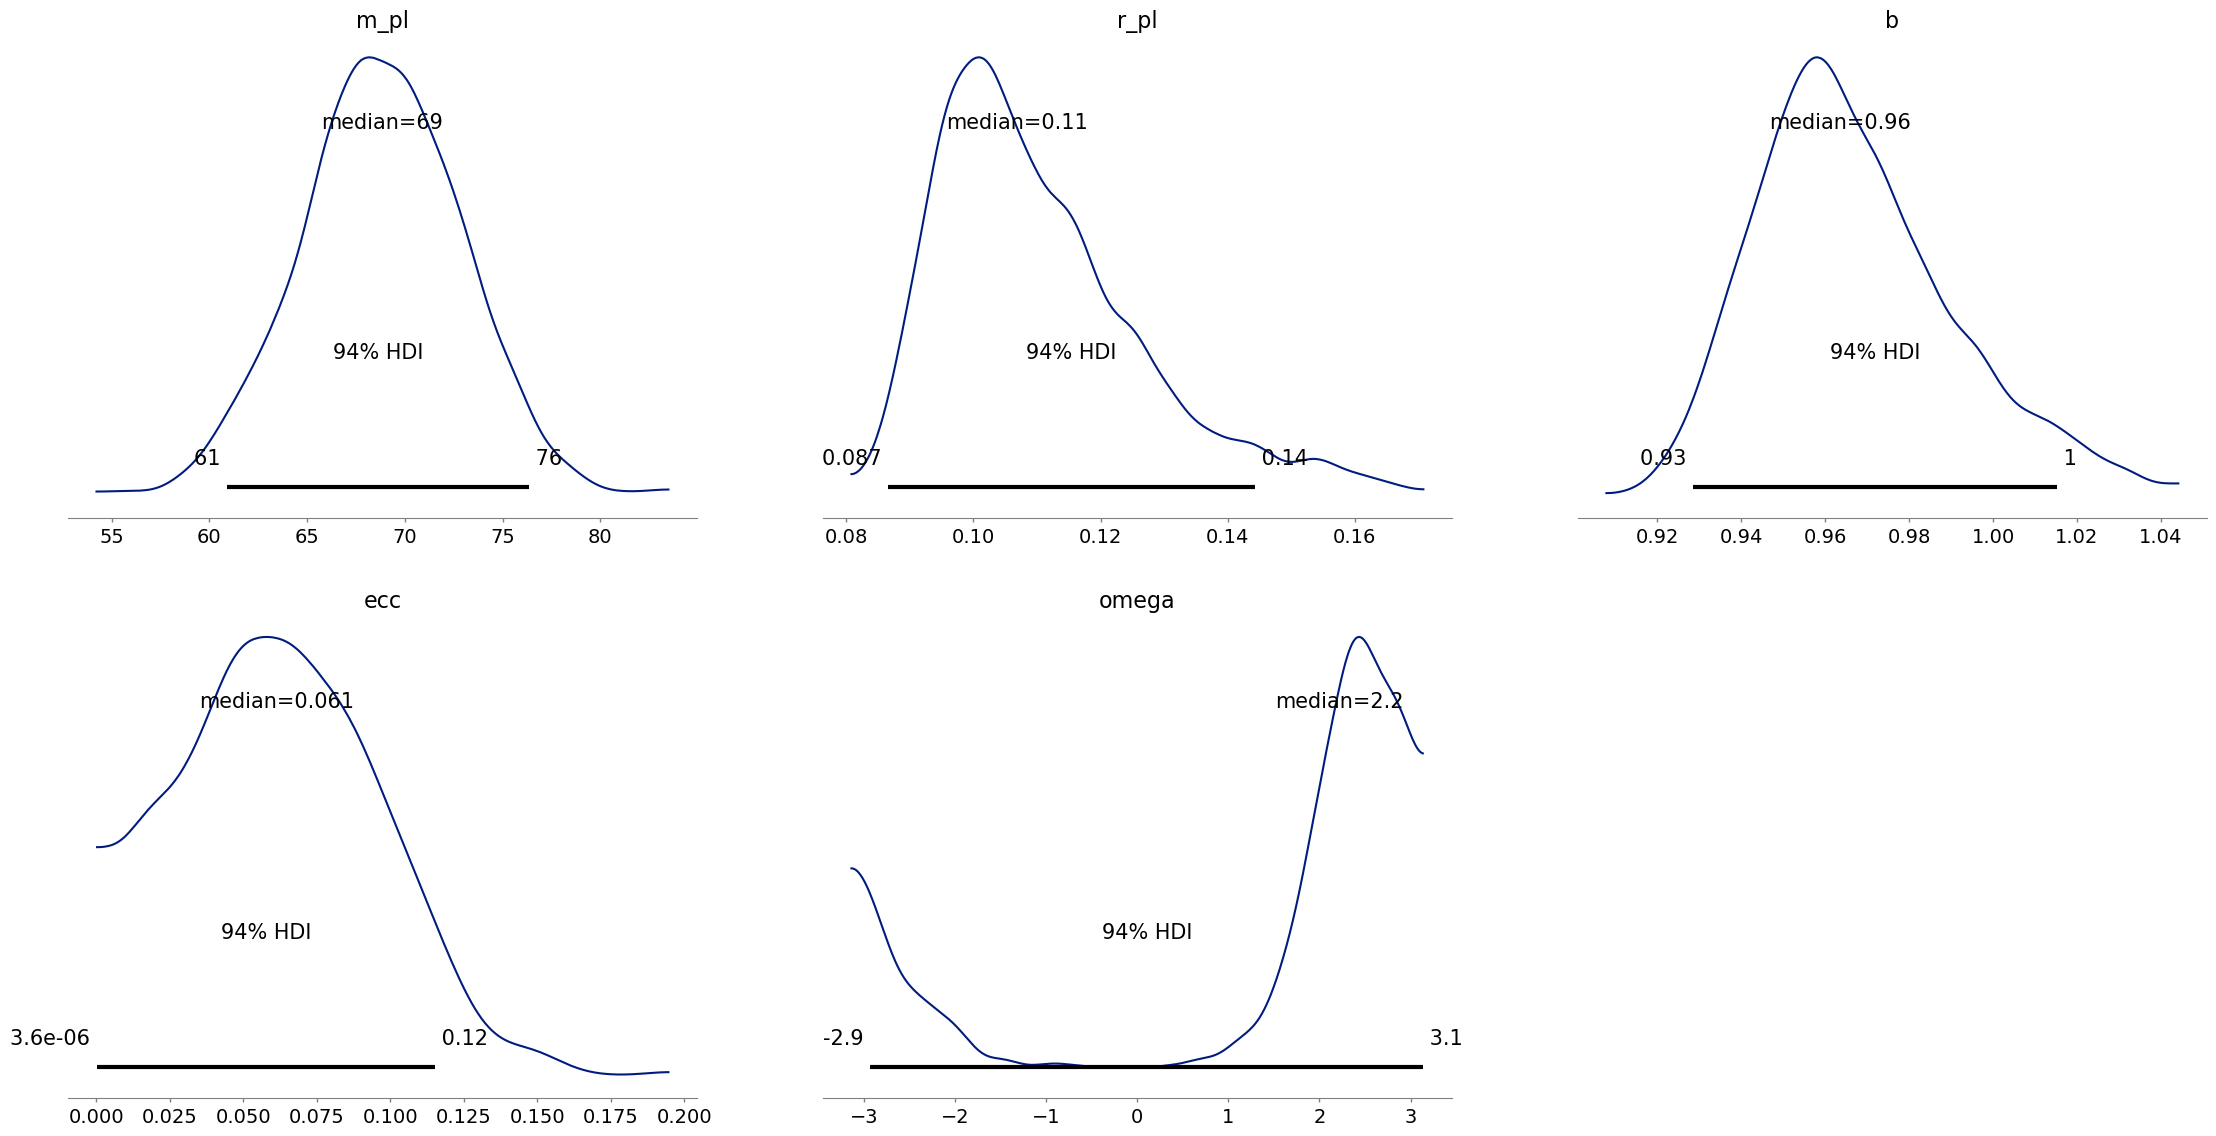

In [94]:
az.plot_posterior(posterior_subset, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'], 
                    combine_dims={"sample"}, point_estimate='median')

plt.show()

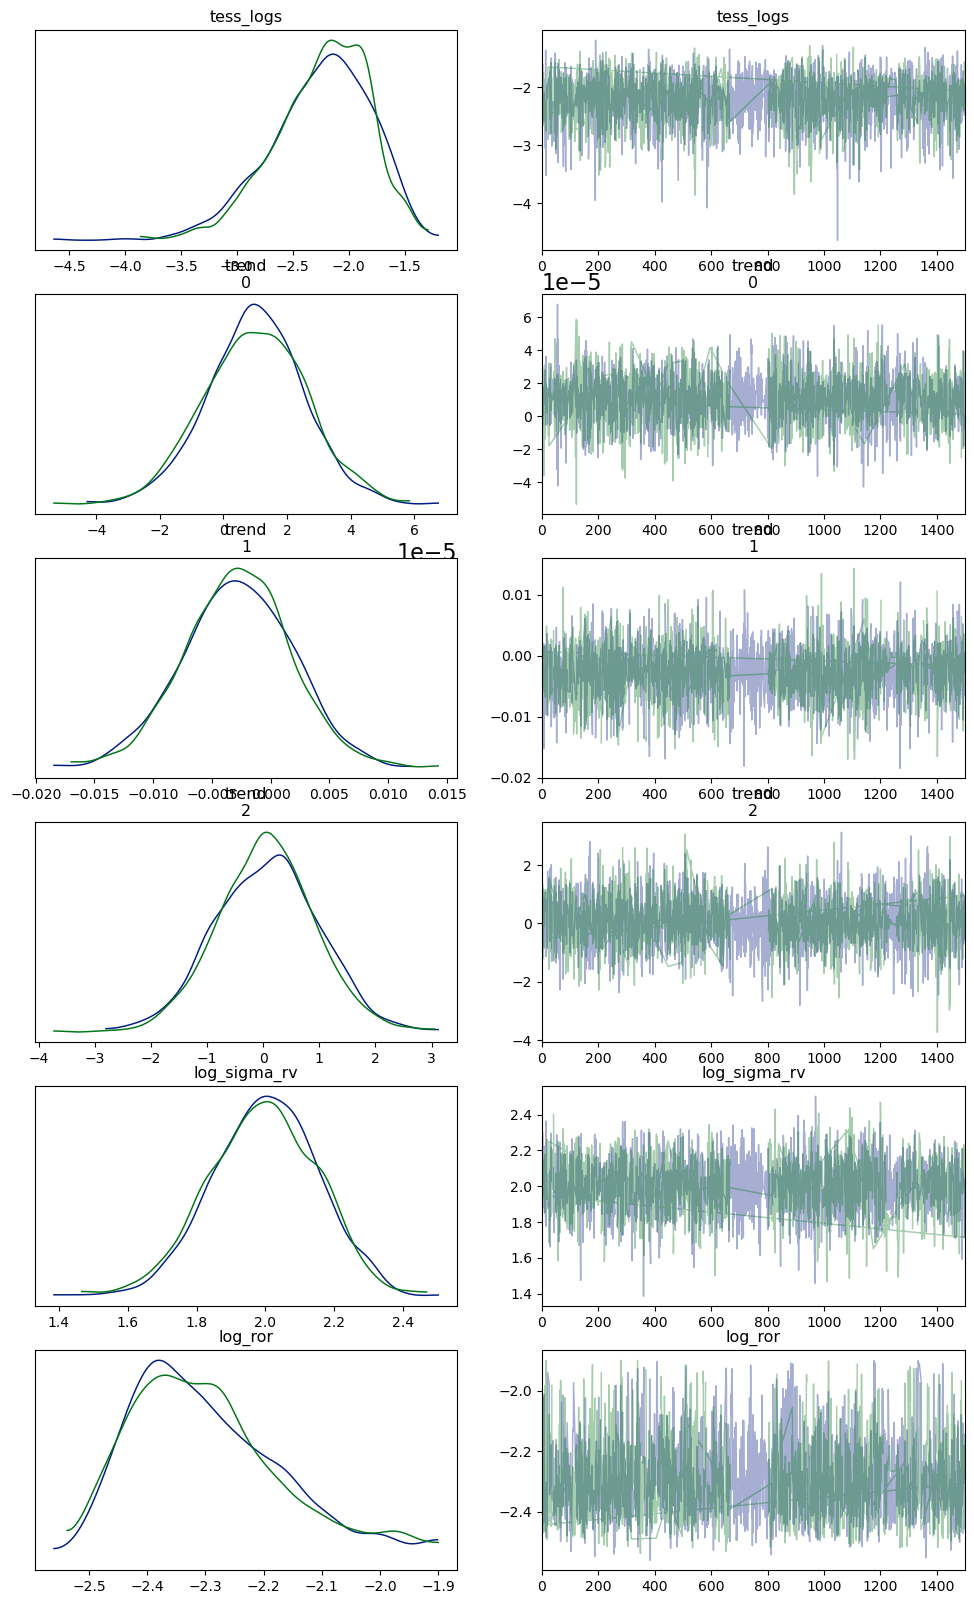

In [95]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag


_ = az.plot_trace(trace_subset.unstack(), var_names=['tess_logs', 'trend','log_sigma_rv', 'log_ror'] # trace or trace_subset.stack()
                                    , compact=False, figsize=(12,20)) 
# plt.savefig('trace_joint_1273_reparam_3.png',dpi=200,bbox_inches='tight')

In [96]:
dict1['r_pl'] = dict1['r_pl']*9.73116

In [97]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1400x1400 with 0 Axes>

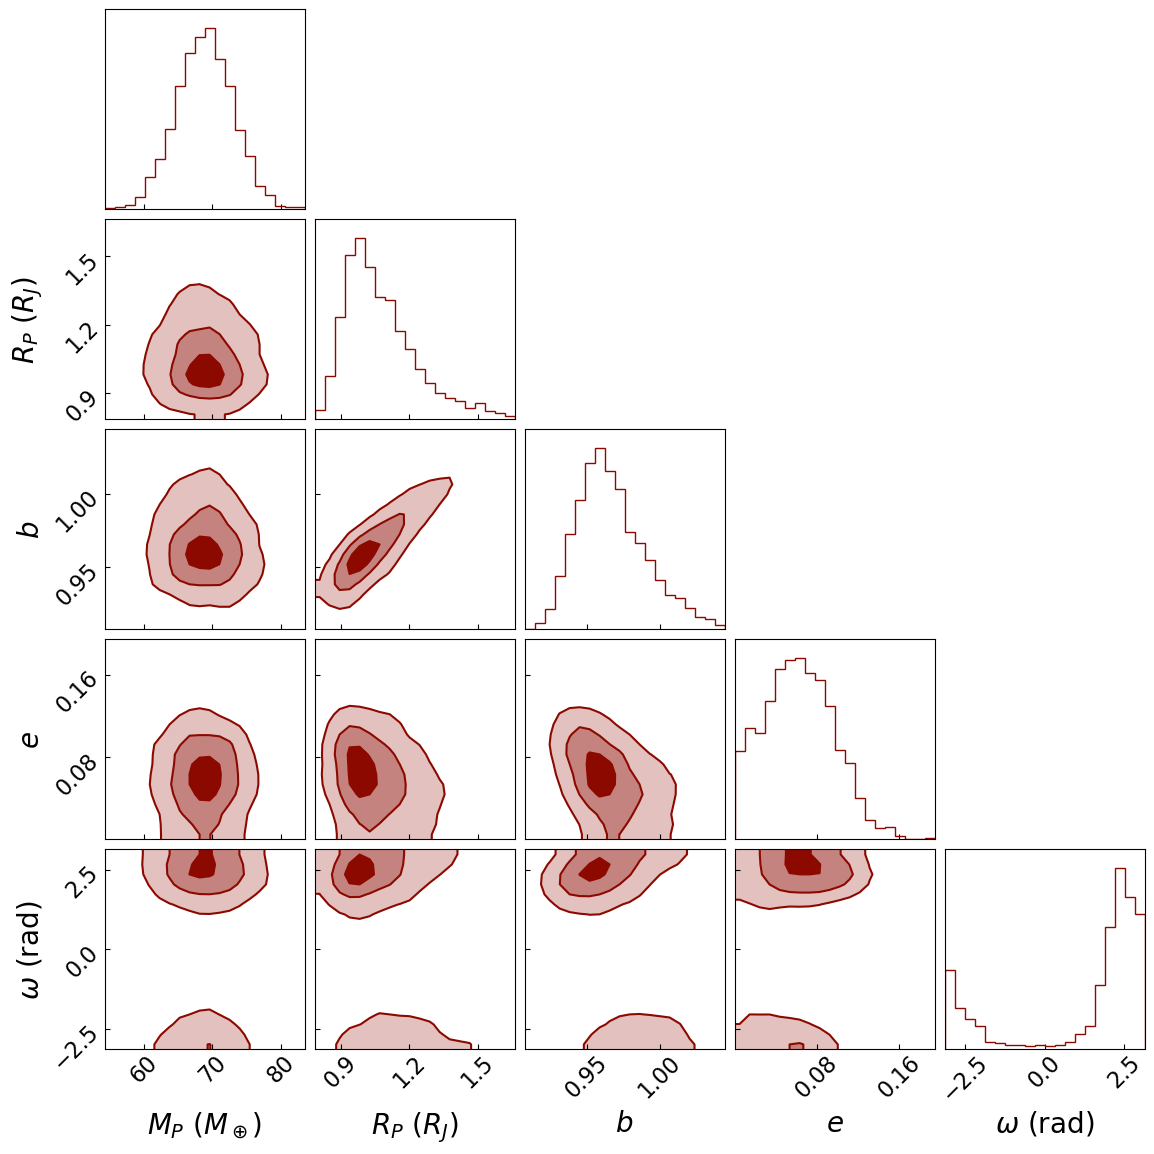

In [98]:
from cProfile import label
import corner

plt.figure(figsize=(14,14))
# figure = corner.corner(dict1, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
#                         labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
#                         show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
#                         labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
figure = corner.corner(dict1, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=False, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1273_paper.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## LC Phase plot

In [102]:
# flat_samps = trace_subset.posterior.stack(sample=("chain", "draw"))

# # Get the posterior median orbital parameters
# p_ = np.median(flat_samps["period"])
# t0_ = np.median(flat_samps["t0"])
# tess_mean = np.median(flat_samps["tess_mean"])
# keplercam_B_mean = np.median(flat_samps["keplercam_B_mean"])
# muscat_zs_mean = np.median(flat_samps["muscat_zs_mean"])
# muscat_r_mean = np.median(flat_samps["muscat_r_mean"])
# muscat_g_mean = np.median(flat_samps["muscat_g_mean"])
# muscat_i_mean = np.median(flat_samps["muscat_i_mean"])

p_ = trace_subset.posterior['period'].median().item()
t0_ = trace_subset.posterior['t0'].median().item()
tess_mean = trace_subset.posterior['tess_mean'].median().item()
keplercam_B_mean = trace_subset.posterior['keplercam_B_mean'].median().item()
muscat_zs_mean = trace_subset.posterior['muscat_zs_mean'].median().item()
muscat_r_mean = trace_subset.posterior['muscat_r_mean'].median().item()
muscat_g_mean = trace_subset.posterior['muscat_g_mean'].median().item()
muscat_i_mean = trace_subset.posterior['muscat_i_mean'].median().item()

In [109]:
means = [tess_mean, keplercam_B_mean, muscat_zs_mean, muscat_r_mean, muscat_g_mean, muscat_i_mean]

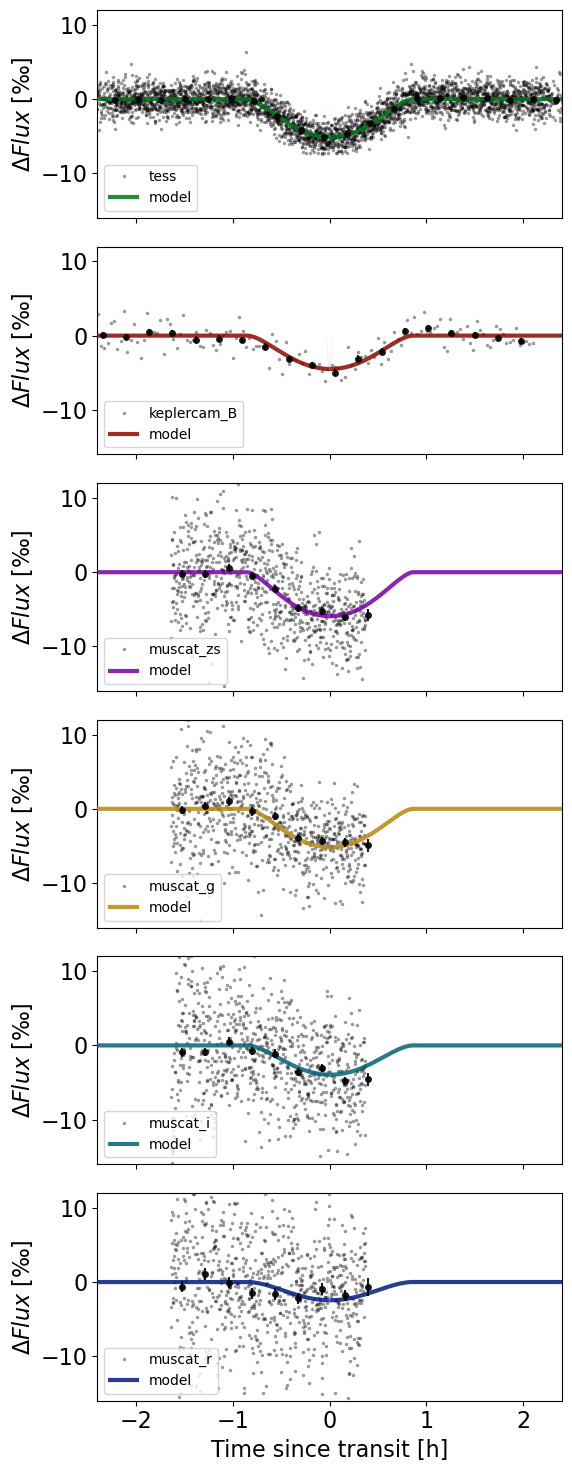

In [113]:
fig, axes = plt.subplots(6, sharex=True, sharey=True, figsize=(6, 15))

for n, name in enumerate(datasets):
    ax = axes[n]

    # plot the folded transits
    x, y, yerr = datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    mean = means[n]
    ax.plot(folded*24, (y  - mean), ".k", alpha=0.4, label=f"{name}", mec="none", ms=5)
    # ax.annotate(
    #     name,
    #     xy=(1, 0),
    #     xycoords="axes fraction",
    #     va="bottom",
    #     ha="right",
    #     xytext=(-3, 3),
    #     textcoords="offset points",
    #     fontsize=14,
    # )
    # Overplot the phase binned light curve with rmse as error bars
    lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
    lcc_binned = lcc.bin(time_bin_size=0.01)
    ax.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
    # overplot the model
    pred = np.percentile(trace_subset.posterior[f"{name}_lc_pred"], [16, 50, 84], axis=-1)
    ax.plot(phase_lc*24, pred[1], color=f"C{n+1}", label="model", zorder=800, linewidth=3, alpha=0.85)
    art = ax.fill_between(phase_lc, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=800)
    art.set_edgecolor("none")
    ax.legend(fontsize=10, loc=3)

axes[-1].set_xlim(-0.10*24, 0.10*24)
axes[-1].set_xlabel("Time since transit [h]")
axes[-1].set_ylim(-16, 12)
for ax in axes:
    ax.set_ylabel(u'$\Delta Flux$ [‰]')

plt.tight_layout()

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

## RV Phase plot

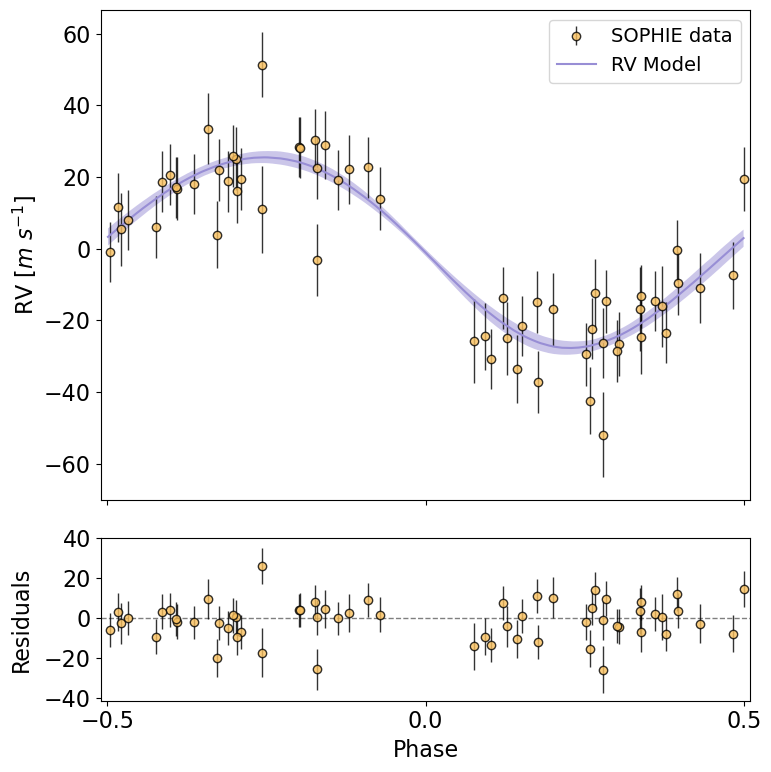

In [117]:
rv_jitter = np.exp(trace_subset.posterior['log_sigma_rv'].median().item())
bkg_ = np.median(trace_subset.posterior['bkg'].values, axis=-1)
rv_model_ = np.median(trace_subset.posterior['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE data', alpha=0.8)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace_subset.posterior['vrad_pred'][inds],[16, 50, 84], axis=-1)
ax1.plot(t_fold[inds]/p_, pred[1], color="#988ED5", label="RV Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#988ED5", alpha=0.5)
art.set_edgecolor("none")
ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-40, -20, 0, 20, 40])
plt.tight_layout()
#plt.savefig('fit_rv_joint_1273.png', dpi=300, bbox_inches='tight', facecolor='white')

### Periodograms with residues

In [118]:
ls_res = LombScargle(data.bjd, y_rv-rv_model_-bkg_)
frequency_res, power_res = ls_res.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)
faps_res = ls_res.false_alarm_level(probabilities)  

/tmp/ipykernel_33866/2120416319.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])


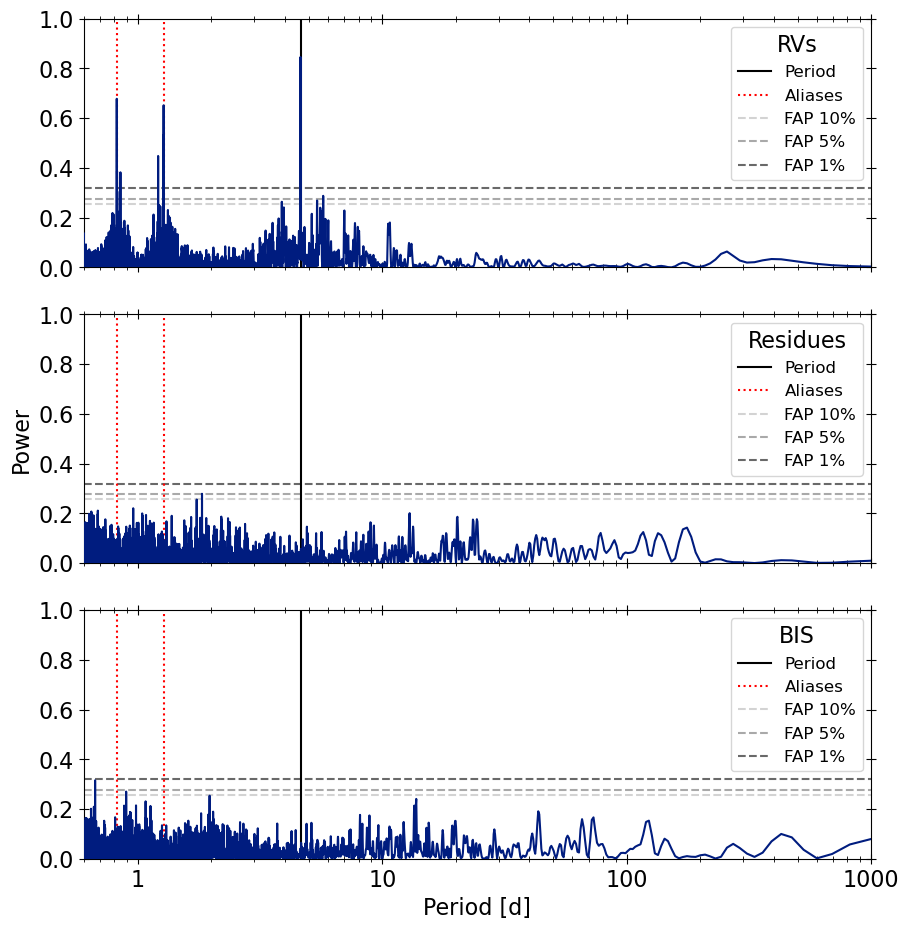

In [119]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10), tight_layout=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
axes[0].plot(1/frequency, power, zorder=10) 
axes[1].plot(1/frequency_res, power_res, zorder=10)
axes[2].plot(1/frequency_bis, power_bis, zorder=10) 

# plot the 'bls_period' as a vertical line behind the plot and show in legend
axes[0].axvline(bls_period, ls='-', color='k', label='Period', zorder=-10)
axes[1].axvline(bls_period, ls='-', color='k', label='Period', zorder=-10)
axes[2].axvline(bls_period, ls='-', color='k', label='Period', zorder=-10)

# add the aliases as red dashed vertical lines
for i in range(3):
    axes[i].axvline(aliases[0], ls=':', color='red', label='Aliases')
    axes[i].axvline(aliases[2], ls=':', color='red')

# overplot the false alarm probabilities
names2 = [faps, faps_res, faps_bis]
for i, names in enumerate(names2):
    axes[i].axhline(names[0], ls='--', color='lightgray', label='FAP 10%', zorder=-20)
    axes[i].axhline(names[1], ls='--', color='darkgray', label='FAP 5%', zorder=-20)
    axes[i].axhline(names[2], ls='--', color='dimgray', label='FAP 1%', zorder=-20)

axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')

axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])
# set legends for all plots in the top right corner
axes[0].legend(loc='upper right', fontsize=12)
axes[1].legend(loc='upper right', fontsize=12)
axes[2].legend(loc='upper right', fontsize=12)
# add legend title
axes[0].legend(loc='upper right', fontsize=12, title='RVs')
axes[1].legend(loc='upper right', fontsize=12, title='Residues')
axes[2].legend(loc='upper right', fontsize=12, title='BIS')
axes[0].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[0].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
axes[2].xaxis.set_major_formatter(formatter)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Period [d]")
plt.ylabel("Power")
# enlarge the xticks
plt.show()

## Density

In [120]:
from uncertainties import ufloat
from uncertainties.umath import *

rpl = ufloat((radio *u.R_jup).to(u.cm).value, (radio_err *u.R_jup).to(u.cm).value)  
mpl = ufloat((masa *u.M_jup).to(u.g).value, (masa_err *u.M_jup).to(u.g).value)

rpl2 = ufloat((radio2 *u.R_jup).to(u.cm).value, (radio2_err *u.R_jup).to(u.cm).value)  
mpl2 = ufloat((masa2 *u.M_jup).to(u.g).value, (masa2_err *u.M_jup).to(u.g).value)

densidad1 = mpl * 1/(4 / 3 * np.pi * rpl**3)
densidad2 = mpl2 * 1/(4 / 3 * np.pi * rpl2**3)

print('densidad1', densidad1)
print('densidad2', densidad2)

densidad1 0.2+/-1.1
densidad2 0.22+/-0.10


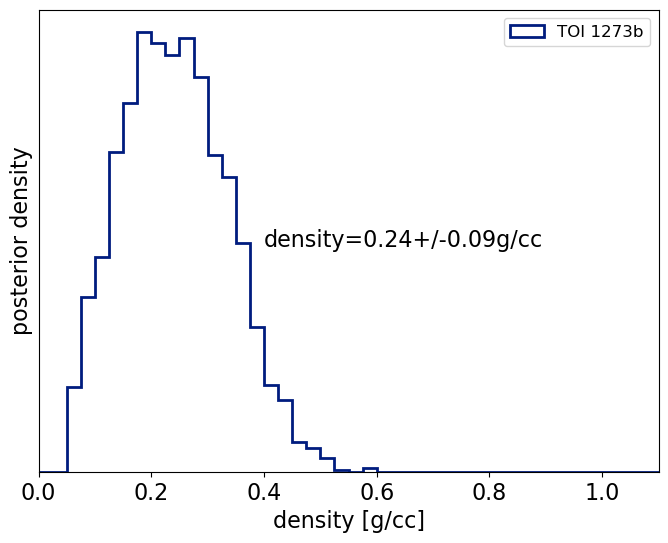

In [121]:
volume = 4 / 3 * np.pi * trace_subset.posterior['r_pl'] ** 3
density = u.Quantity(trace_subset.posterior['m_pl'] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1273b',
        density=True,)
plt.yticks([])
plt.text(0.4, 2, 'density={:.2f}+/-{:.2f}g/cc'.format(np.median(density),np.std(density)))
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1273_reparam.png',dpi=200,bbox_inches='tight')